In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt

import hugs
from hugs.database.tables import Source, Synth

In [2]:
import os
sys.path.append('../scripts')

In [3]:
import pandas as pd
from astropy.table import Table
default_synth_dir = '/tigress/jgreco/hsc-s18a/synths/global'

In [4]:
synth_fn = os.path.join(default_synth_dir, 'global-synth-cat.fits')
cat_fn = '../data/hugs-cat.csv'

In [5]:
hugs_cat = pd.read_csv(cat_fn)
synth_cat = Table.read(synth_fn)

In [6]:
from synth_analysis import match_synths

In [151]:
from astropy import units as u

In [152]:
hugs_match, synth_match = match_synths(hugs_cat, synth_cat, 0.8 * u.arcsec)

INFO: finding nearest neighbor within 0.8 arcsec
INFO: finding second nearest neighbor within 0.8 arcsec
INFO: keeping match with better radius measurement


In [153]:
len(synth_match), len(hugs_match) 

(134446, 134446)

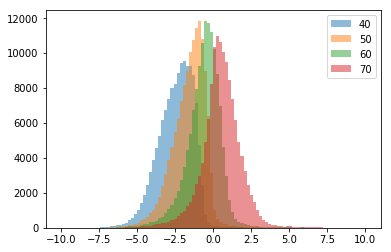

In [154]:
for frac in np.arange(40, 80, 10):
    plt.hist(hugs_match['flux_radius_' + str(frac) + '_i'] - synth_match['r_e'], 
             range=[-10, 10], bins=100, label=str(frac), alpha=0.5)
plt.legend()

In [162]:
def _clip_outlier_mask(cat, param_name=None, percentiles=[0.001, 99.999]):
    if param_name is not None:
        pmin, pmax = np.percentile(cat[param_name], percentiles)
        mask = (cat[param_name] > pmin) & (cat[param_name] < pmax)
    else: 
        pmin, pmax = np.percentile(cat, percentiles)
        mask = (cat > pmin) & (cat < pmax)
    return mask


def _get_clipped_param(hugs_cat, hugs_param_name, synth_cat, synth_param_name,
                       **kwargs):
    mask = _clip_outlier_mask(hugs_cat, hugs_param_name, **kwargs)
    hugs_param = hugs_cat[hugs_param_name][mask]
    synth_param = synth_cat[synth_param_name][mask]
    return hugs_param, synth_param

In [192]:
def _get_16_50_84(param):
    lo, med, hi = np.percentile(param, [16, 50, 84])
    return lo, med, hi
    

def parameter_accuracy(hugs_cat, synth_cat, fig_dir, r_e_param='flux_radius_60_i', 
                      color_mag='mag_ap9', fontsize=22):
 
    f1, a1 = plt.subplots(3, 2, figsize=(10, 10))
    f1.subplots_adjust(hspace=0.35)
    
    
    hugs_r_e, synth_r_e = _get_clipped_param(
        hugs_cat, r_e_param, synth_cat, 'r_e', percentiles=[0.1, 99.9])
    a1[0, 0].plot(synth_r_e, hugs_r_e, ',', alpha=0.2)
    a1[0, 0].plot([synth_r_e.min(), synth_r_e.max()],
                  [synth_r_e.min(), synth_r_e.max()],
                  'k--', lw=2, zorder=10)
    a1[0, 1].hist(synth_r_e - hugs_r_e, bins='auto', alpha=0.5)
    a1[0, 1].axvline(x=0, ls='-', lw=2, color='k')
    a1[0, 1].set_xlim(-5, 5)
    a1[0, 0].set_xlabel(r'$r_e$', fontsize=fontsize)
    a1[0, 0].set_ylabel(r_e_param.replace('_', ' '), fontsize=fontsize-2)
    a1[0, 1].set_xlabel(r'$\delta r_e$', fontsize=fontsize)
    stat_lines = _get_16_50_84(synth_cat['r_e'] - hugs_cat[r_e_param])
    for stat in stat_lines:
        a1[0, 1].axvline(x=stat, ls='--', lw=2, c='tab:red', alpha=0.7)
    
    
    hugs_m_g, synth_m_g = _get_clipped_param(
    hugs_cat, 'mag_auto_g', synth_cat, 'm_g', percentiles=[0.001, 99.999])
    a1[1, 0].plot(synth_m_g, hugs_m_g, ',', alpha=0.2)
    a1[1, 0].plot([synth_m_g.min(), synth_m_g.max()],
                  [synth_m_g.min(), synth_m_g.max()],
                  'k--', lw=2, zorder=10)
    a1[1, 1].hist(synth_m_g - hugs_m_g, bins='auto', alpha=0.5)
    a1[1, 1].axvline(x=0, ls='-', lw=2, color='k')
    a1[1, 1].set_xlim(-1, 1)
    a1[1, 0].set_xlabel(r'$m_g$', fontsize=fontsize)
    a1[1, 0].set_ylabel('mag auto g', fontsize=fontsize-2)
    a1[1, 1].set_xlabel(r'$\delta m_g$', fontsize=fontsize)
    stat_lines = _get_16_50_84(synth_cat['m_g'] - hugs_cat['mag_auto_g'])
    for stat in stat_lines:
        a1[1, 1].axvline(x=stat, ls='--', lw=2, c='tab:red', alpha=0.7)

        
    hugs_mu_ave = hugs_match['mag_auto_g'] + 2.5 * np.log10(2 * np.pi * hugs_match['flux_radius_50_g']**2)
    hugs_match['hugs_mu_ave'] = hugs_mu_ave
    hugs_mu_ave, synth_mu_ave = _get_clipped_param(
    hugs_match, 'hugs_mu_ave', synth_cat, 'mu_e_ave_g', percentiles=[0.001, 99.999])
    a1[2, 0].plot(synth_mu_ave, hugs_mu_ave, ',', alpha=0.2)
    a1[2, 0].plot([synth_mu_ave.min(), synth_mu_ave.max()],
                  [synth_mu_ave.min(), synth_mu_ave.max()],
                  'k--', lw=2, zorder=10)
    a1[2, 0].set_ylim(22, 30)
    a1[2, 1].hist(synth_mu_ave - hugs_mu_ave, bins='auto', alpha=0.5)
    a1[2, 1].axvline(x=0, ls='-', lw=2, color='k')
    a1[2, 1].set_xlim(-1, 1)
    a1[2, 0].set_xlabel(r'$\bar{\mu}_\mathrm{eff}(g)$', fontsize=fontsize)
    a1[2, 0].set_ylabel('mu ave g', fontsize=fontsize-2)
    a1[2, 1].set_xlabel(r'$\delta \bar{\mu}_\mathrm{eff}(g)$', fontsize=fontsize)
    stat_lines = _get_16_50_84(synth_cat['mu_e_ave_g'] - hugs_match['hugs_mu_ave'])
    for stat in stat_lines:
        a1[2, 1].axvline(x=stat, ls='--', lw=2, c='tab:red', alpha=0.7)

    synth_gi = synth_match['g-i'][0]
    synth_gr = synth_match['g-r'][0]

    hugs_gi = hugs_match[color_mag + '_g'] - hugs_match[color_mag + '_i']
    hugs_gr = hugs_match[color_mag + '_g'] - hugs_match[color_mag + '_r']
    
    hugs_gi = hugs_gi[_clip_outlier_mask(hugs_gi, percentiles=[0.1, 99.9])]
    hugs_gr = hugs_gr[_clip_outlier_mask(hugs_gr, percentiles=[0.1, 99.9])]
    
    f2, a2 = plt.subplots()
    a2.hist(hugs_gi, bins='auto', label=r'$g-i$', alpha=0.5)
    a2.axvline(x=synth_gi, ls='--', lw=2, color='k')
    a2.hist(hugs_gr, bins='auto', label=r'$g-r$', alpha=0.5)
    a2.axvline(x=synth_gr, ls='--', lw=2, color='k')
    a2.legend(loc=0, fontsize=18)
    a2.set_xlabel('color', fontsize=fontsize)

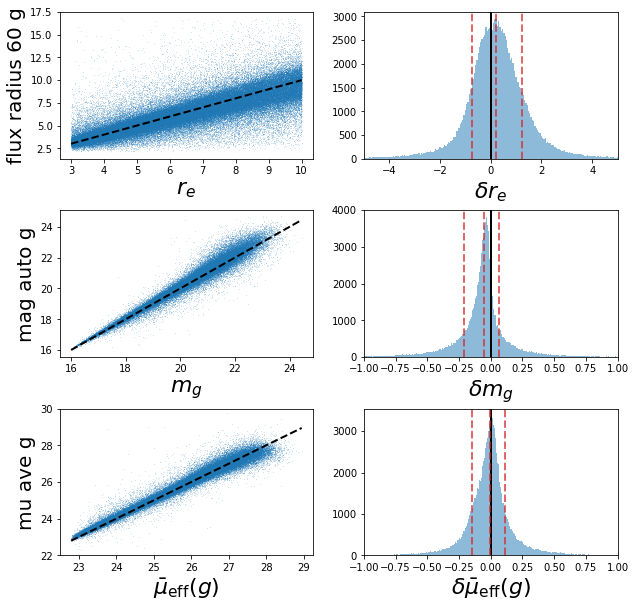

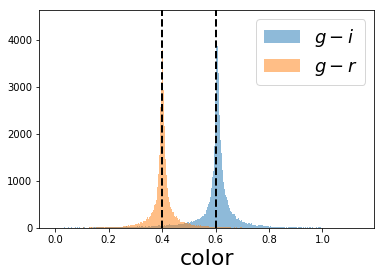

In [193]:
parameter_accuracy(hugs_match, synth_match, '.', r_e_param='flux_radius_60_g')